In [1]:
import pandas as pd #Import pandas for operations

In [2]:
dataframe = pd.read_csv('data/sdss_100k_galaxy_form_burst.csv', low_memory=False, header=1)

print("Dataset loaded successfully!")
print(f"Dataset shape: {dataframe.shape}")
print(f"Columns: {list(dataframe.columns)}")
print(f"Datatypes: {dataframe.dtypes}")

Dataset loaded successfully!
Dataset shape: (100000, 43)
Columns: ['objid', 'specobjid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i', 'modelFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r', 'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z', 'class', 'subclass', 'redshift', 'redshift_err']
Datatypes: objid             int64
specobjid        uint64
ra              float64
dec             float64
u               float64
g               float64
r               float64
i               float64
z               float64
modelFlux_u     float64
modelFlux_g     float64
modelFlux_r     float64
modelFlux_i     float64
modelFlux_z     float64
petroRad_u      float64
petroRad_g      float64
petroRad_i      float64


In [4]:
# dataframe['subclass'].unique()


array(['STARFORMING', 'STARBURST'], dtype=object)

In [5]:
#1 Data pre-processing

#1.1.1 remove unnecessary columns
modified_dataframe = dataframe.drop(['objid', 'specobjid', 'class'], axis=1)

#1.1.2 Encode subclass category accordingly
modified_dataframe['subclass'] = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

#1.2.1 Split dataset into Test and Training data. (80% Training - 20% Test)
main_training_data = modified_dataframe.sample(frac=0.8)
testing_data = modified_dataframe.drop(main_training_data.index)

#1.2.2 Split Test data into Test and Validation Set. (70% Training - 30% Validation)
training_set = main_training_data.sample(frac=0.7)
validation_set = main_training_data.drop(training_set.index)


In [15]:
#Visualize data.
#1. Training Set Info
print(f"Training Dataset shape: {training_set.shape}")
print(f"Training Dataset Columns: {list(training_set.columns)}")

#2. Testing Set Info
print(f"Testing Dataset shape: {testing_data.shape}")
print(f"Testing Dataset Columns: {list(testing_data.columns)}")

#3. Validation Set Info
print(f"Validation Dataset shape: {validation_set.shape}")
print(f"Validation Dataset Columns: {list(validation_set.columns)}")

assert(len(training_set) + len(testing_data) + len(validation_set) == len(modified_dataframe)) #Confirm that the lengths match.





Training Dataset shape: (56000, 40)
Training Dataset Columns: ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i', 'modelFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r', 'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z', 'subclass', 'redshift', 'redshift_err']
Testing Dataset shape: (20000, 40)
Testing Dataset Columns: ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i', 'modelFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r', 'psfMag_g', 'psfMag_i', 'psfMag_z', 'expA

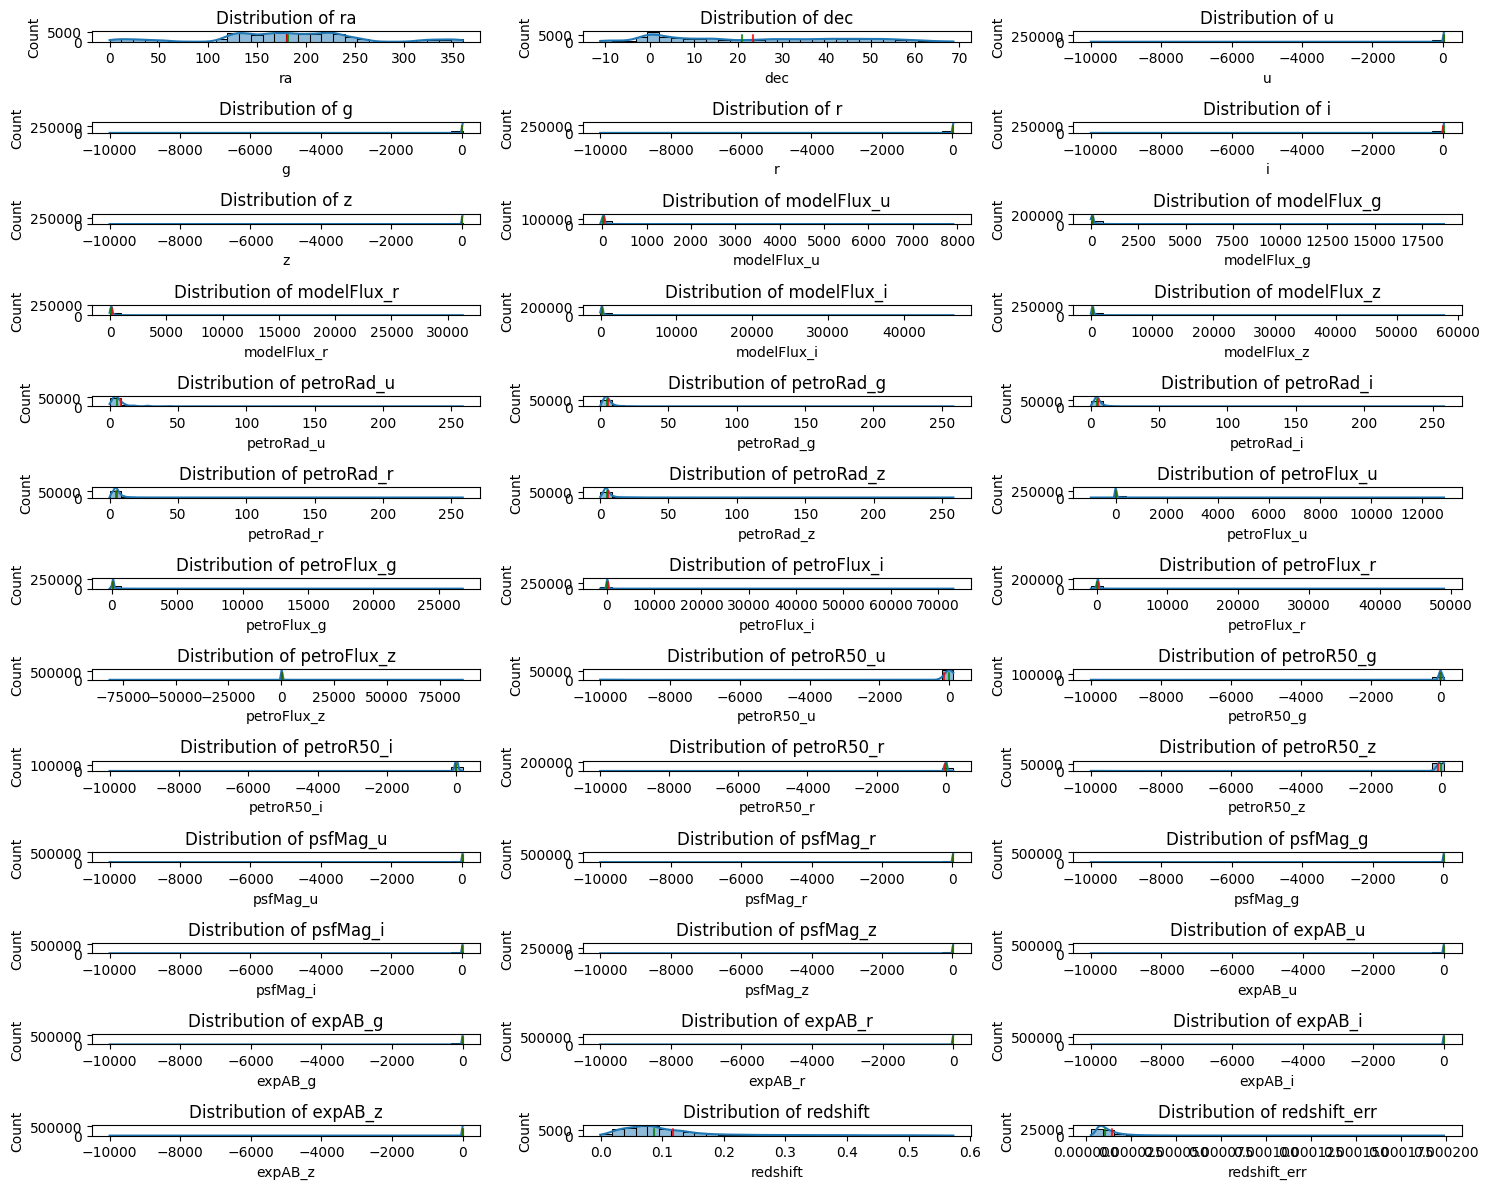

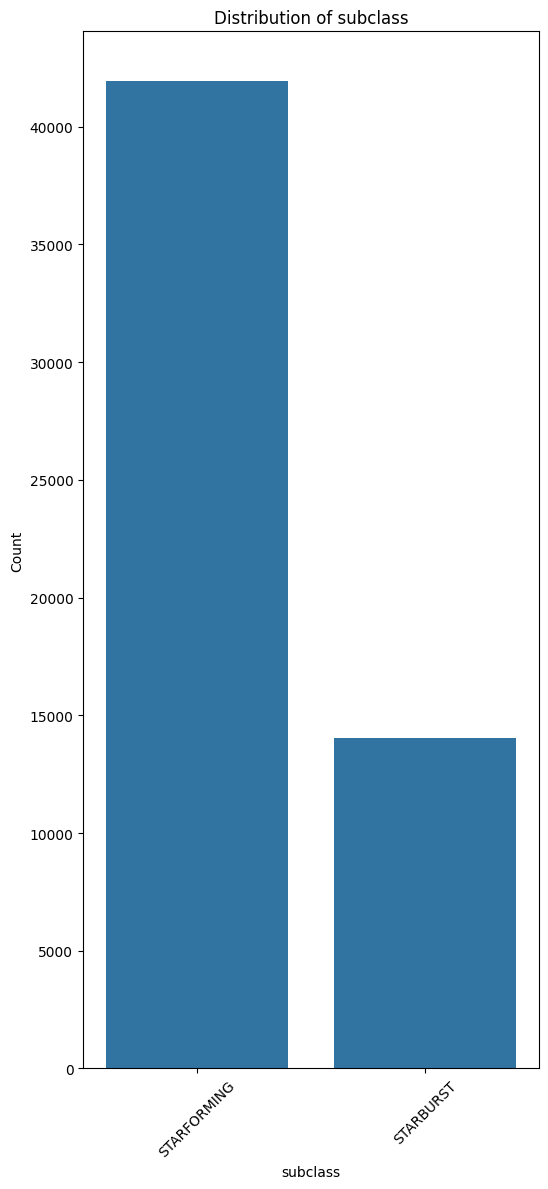

In [16]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_distributions_seaborn(df, figsize=(15, 12)):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

    # Plot numerical distributions
    if len(numerical_cols) > 0:
        n_rows = (len(numerical_cols) + 2) // 3
        fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
        axes = axes.flatten()

        for i, col in enumerate(numerical_cols):
            sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=30)
            axes[i].axvline(df[col].mean(), color='red', linestyle='--', alpha=0.8)
            axes[i].axvline(df[col].median(), color='green', linestyle='--', alpha=0.8)
            axes[i].set_title(f'Distribution of {col}')

        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    # Plot categorical distributions
    if len(categorical_cols) > 0:
        n_rows = (len(categorical_cols) + 2) // 3
        fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
        axes = axes.flatten()

        for i, col in enumerate(categorical_cols):
            value_counts = df[col].value_counts().head(10)
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].set_ylabel('Count')

        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

plot_distributions_seaborn(training_set)

In [18]:
from sklearn.preprocessing import StandardScaler
#2. Normalize data.

#2. Apply mean-centering & variance scaling to data

#2.1. Define function
def standardize_with_sklearn(df):
    """
    Use scikit-learn's StandardScaler for robust standardization
    """
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

    # Create a copy and only scale numerical columns
    df_normalized = df.copy()

    if len(numerical_cols) > 0:
        scaler = StandardScaler()
        df_normalized[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df_normalized

#2.2. Apply standardization
testing_dataset_normalized = standardize_with_sklearn(testing_data)
training_dataset_normalized = standardize_with_sklearn(training_set)
validation_dataset_normalized = standardize_with_sklearn(validation_set)


In [ ]:
#3. Begin Training Model.

